<a href="https://colab.research.google.com/github/lexxxegorov/HOMEWORKPY/blob/master/Task__8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B tests с Python




<a id="Libraries"></a>
##  Загрузка библиотек 

In [3]:
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind

import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')



In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import norm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#Подгружаем данные с гугл диска
from google.colab import drive
drive.mount('/content/drive')


ab_result = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/AB_Test_Results (2).xlsx')

ab_result.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [10]:
ab_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [11]:
ab_result.shape

(10000, 3)

In [91]:
ab_result.describe()

,USER_ID,REVENUE
count,"10,000.00","10,000.00"
mean,"4,981.08",0.10
std,"2,890.59",2.32
min,2.00,0.00
25%,"2,468.75",0.00
50%,"4,962.00",0.00
75%,"7,511.50",0.00
max,"10,000.00",196.01


In [13]:
ab_result.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [17]:
#ab_result['VARIANT_NAME'].value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [18]:
ab_result['USER_ID'].value_counts()

5652    6
8359    6
668     6
9101    6
4879    6
       ..
5455    1
1399    1
6967    1
3156    1
9468    1
Name: USER_ID, Length: 6324, dtype: int64

In [60]:
#Проверяем на уникальность USER ID
ab_result.groupby('USER_ID').agg({'VARIANT_NAME' : 'nunique'}).query('VARIANT_NAME>1').count()

VARIANT_NAME    1541
dtype: int64

In [58]:
double_users = ab_result.groupby('USER_ID').agg({'VARIANT_NAME' : 'nunique'}).reset_index().query('VARIANT_NAME>1')['USER_ID'].unique()
double_users



array([    3,    10,    18, ...,  9982,  9996, 10000])

In [92]:
ab_result[ab_result['USER_ID'] == 9982] 

,USER_ID,VARIANT_NAME,REVENUE
1758,9982,variant,0.00
7308,9982,control,0.00


***Выяснили, что у нас есть неуникальные USER_ID, удаляем их. Так данная информация некорректна, один и тотже юзер не может попадать в обе группы.  ***

In [101]:
ab_out_double = ab_result.query('USER_ID not in @double_users')
ab_out_double


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00
4,6174,variant,0.00
5,2380,variant,0.00
7,9168,control,0.00
9,7548,control,0.00
...,...,...,...
9993,2400,variant,0.00
9994,3129,control,0.00
9996,502,variant,0.00
9998,7741,control,0.00


***После удаления сокращается кол-во юзеров до 6070.***

In [102]:
ab_out_double.shape

(6070, 3)

In [103]:
ab_out_double['VARIANT_NAME'].value_counts()

variant    3044
control    3026
Name: VARIANT_NAME, dtype: int64

**Посмотрим на группы отдельно**

In [104]:
ab_out_double[ab_out_double['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,"3,044.00","3,044.00"
mean,"4,976.98",0.06
std,"2,876.74",0.76
min,4.00,0.00
25%,"2,487.25",0.00
50%,"4,950.00",0.00
75%,"7,376.50",0.00
max,"9,995.00",23.04


In [105]:
ab_out_double[ab_out_double['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,"3,026.00","3,026.00"
mean,"4,990.39",0.16
std,"2,919.67",3.71
min,2.00,0.00
25%,"2,457.75",0.00
50%,"4,949.50",0.00
75%,"7,603.75",0.00
max,"9,998.00",196.01


**Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный revenue в группе variant сильно меньше, чем в контрольной версии control. Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.**

#Проверка на нормальность распределения и применение статистических критериев

##Метрика доход на юзера

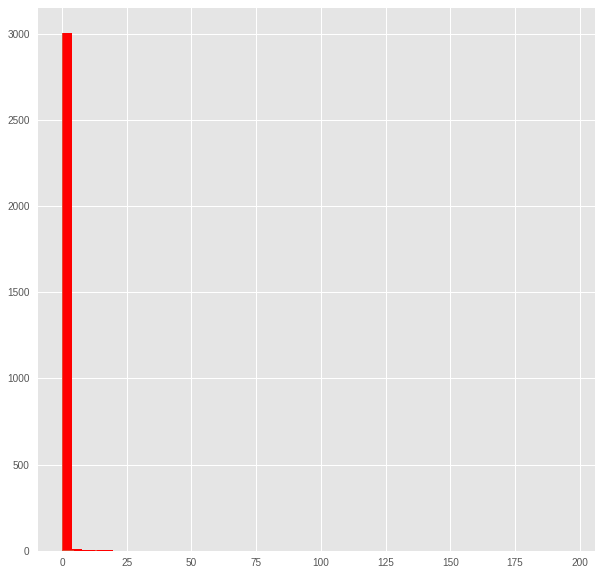

In [106]:
plt.figure(figsize=(10, 10))
variant_revenue_all = ab_out_double['REVENUE'][ab_out_double['VARIANT_NAME']=='variant']
control_revenue_all = ab_out_double['REVENUE'][ab_out_double['VARIANT_NAME']=='control']


plt.hist(control_revenue_all, color='r', bins=50)
plt.hist(variant_revenue_all,  bins=50)


plt.show()

In [107]:
ttest_ind(variant_revenue_all, control_revenue_all, equal_var = False)

Ttest_indResult(statistic=-1.403762252371675, pvalue=0.1604844017690842)

**pvalue=0.1604844017690842 > a, принимаем нулевую гипотезу, статистических значемых различий нет.**

In [62]:
# Проверка на нормальность тест Колмогорова-Смирнова

from scipy.stats import kstest
print(kstest(variant_revenue_all, 'norm'))
print(kstest(control_revenue_all, 'norm'))


KstestResult(statistic=0.5, pvalue=0.0)
KstestResult(statistic=0.5, pvalue=0.0)


In [64]:
# значимости Манна Уитни
from scipy.stats import mannwhitneyu
mannwhitneyu(variant_revenue_all, control_revenue_all)


MannwhitneyuResult(statistic=4588312.0, pvalue=0.2444173738649208)

In [65]:
from scipy.stats import norm

In [108]:
# Функция бутстрепа

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
            ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
            ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    # значения квантилей
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('Значение метрики')
    plt.ylabel('Частота')
    plt.title("Гистограмма распределения")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

100%|██████████| 10000/10000 [00:05<00:00, 1797.69it/s]


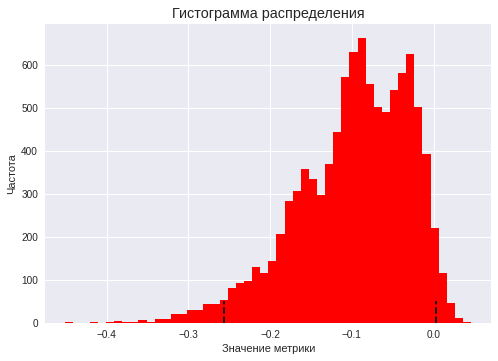

p_value 0.15600881418575768


In [71]:
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn')
pd.options.display.float_format ='{:,.2f}'.format
# если 0 включен в доверительный интернвал между группами нет разницы
# в результате хранится разница двух распределений, ДИ и pvalue
booted_data = get_bootstrap(ab_out_double['REVENUE'][ab_out_double['VARIANT_NAME']=='variant'],
                            ab_out_double['REVENUE'][ab_out_double['VARIANT_NAME']=='control'],
                            boot_it = 10000) 

print("p_value", booted_data["p_value"])
# print("quants" , booted_data["quants"])


##Метрика доля юзеров с покупкой

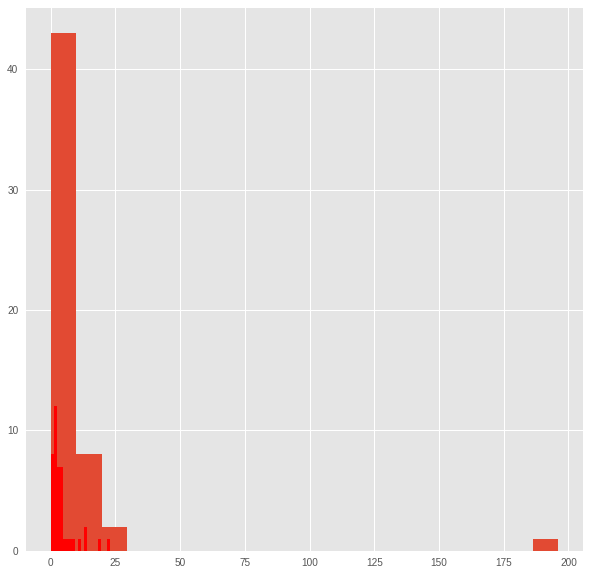

In [75]:
plt.figure(figsize=(10, 10))
variant_visit = ab_out_double['REVENUE'][(ab_out_double['VARIANT_NAME']=='variant')&(ab_out_double['REVENUE'] > 0)]
control_visit = ab_out_double['REVENUE'][(ab_out_double['VARIANT_NAME']=='control')&(ab_out_double['REVENUE'] > 0)]
plt.hist(control_visit,  bins=20)
plt.hist(variant_visit, color='r', bins=20)

plt.show()

***По итогу анализа результатов, можно сказать, что статистической разницы в обоих вариантов нет. Изменения значимо не увеличили доход. В контрольной группе есть большой выброс, который влияет на средний доход. Изменения не выкатываем. ***

In [111]:
ab_result[ab_result['REVENUE'] >= 50] 

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
6447,2881,variant,58.63
7642,7206,variant,57.46
